Useful links:

https://medium.com/@imabhi1216/fine-tuning-a-vision-transformer-vit-model-with-a-custom-dataset-37840e4e9268#f0a3

https://www.kaggle.com/code/luthei/vit-vs-cnn-on-wikiart/notebook#3.2-Test-Accuracy



In [ ]:
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time

from datasets import load_dataset

from transformers import ViTModel
from transformers import ViTImageProcessor, Trainer, TrainingArguments
from transformers import EvalPrediction
import evaluate
from sklearn.metrics import top_k_accuracy_score
import torch.quantization
from collections import Counter
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


c:\Users\Wiktoria\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset
https://huggingface.co/datasets/huggan/wikiart

In [3]:
def plot_histogram(data, title):
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=range(min(data), max(data) + 2), edgecolor='black')
    plt.title(title)
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.show()

In [4]:
dataset = load_dataset("huggan/wikiart", split="train")

In [5]:
print(f"Total number of records: {len(dataset)}")
print(f"Number of columns: {len(dataset.column_names)}")
print(dataset.column_names)

Total number of records: 81444
Number of columns: 4
['image', 'artist', 'genre', 'style']


In [6]:
unique_genres = set(dataset['genre'])
print(f"Number of genres: {unique_genres.__len__()}")
print(f"Unique genres: {unique_genres}")

Number of genres: 11
Unique genres: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


In [7]:
unique_style = set(dataset['style'])
print(f"Number of styles: {unique_style.__len__()}")
print(f"Unique styles: {unique_style}")

Number of styles: 27
Unique styles: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


We will be using 3 columns: image, style and genre

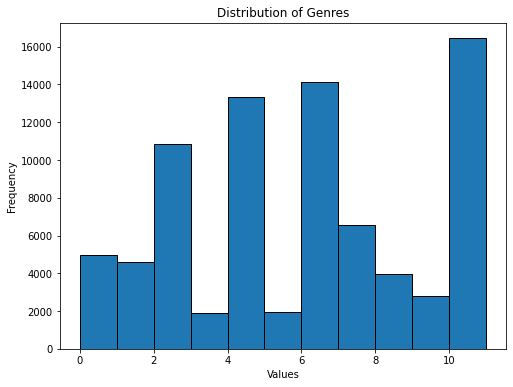

In [8]:
plot_histogram(dataset['genre'], "Distribution of Genres")

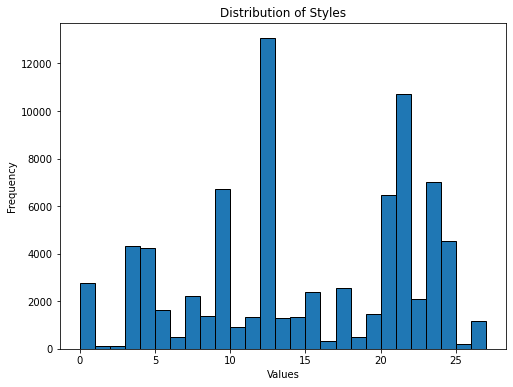

In [9]:
plot_histogram(dataset['style'], "Distribution of Styles")

Concerning disproportion  in distribution of genres. This may negatively impact the classification results. 

## ViT

### Class resampling

In [10]:
# Count samples per (genre, style)
counter = Counter(dataset['style'])
min_count = min(counter.values())

print(f"Minimum count of samples in any style: {min_count}")

# Group indices by (genre, style)
grouped_indices = {}
for idx, (s) in enumerate(dataset['style']):
    grouped_indices.setdefault(s, []).append(idx)

# Sample min_count indices from each group
selected_indices = []
for indices in grouped_indices.values():
    selected_indices.extend(random.sample(indices, min_count))

# Select balanced subset
dataset = dataset.select(selected_indices)
print(f"Balanced dataset size: {len(dataset)}")

Minimum count of samples in any style: 98
Balanced dataset size: 2646


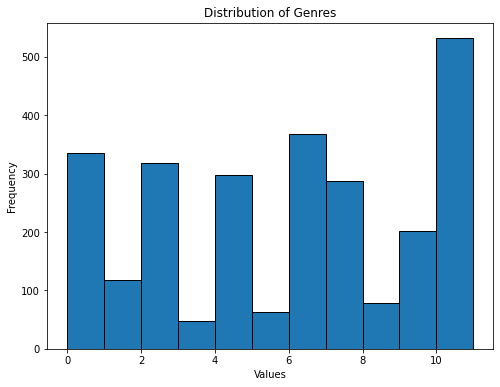

In [11]:
plot_histogram(dataset['genre'], "Distribution of Genres")

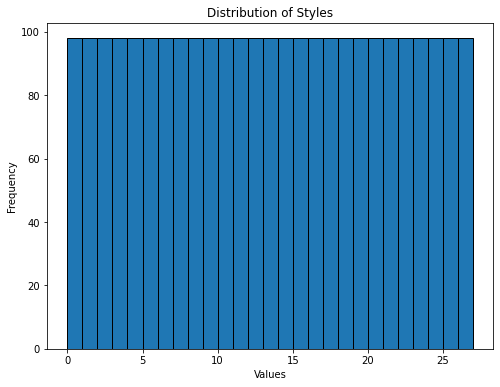

In [12]:
plot_histogram(dataset['style'], "Distribution of Styles")

### Encoding genre and style labels (?)

In [13]:
genres = list(set(dataset['genre']))
styles = list(set(dataset['style']))

label2id = {g: i for i, g in enumerate(genres)}
id2label = {i: g for g, i in label2id.items()}

style2id = {s: i for i, s in enumerate(styles)}
id2style = {i: s for s, i in style2id.items()}

def encode_labels(example):
    example['genre_label'] = label2id[example['genre']]
    example['style_label'] = style2id[example['style']]
    return example

dataset = dataset.map(encode_labels)

Map: 100%|██████████| 2646/2646 [00:04<00:00, 578.81 examples/s]


### Data examples

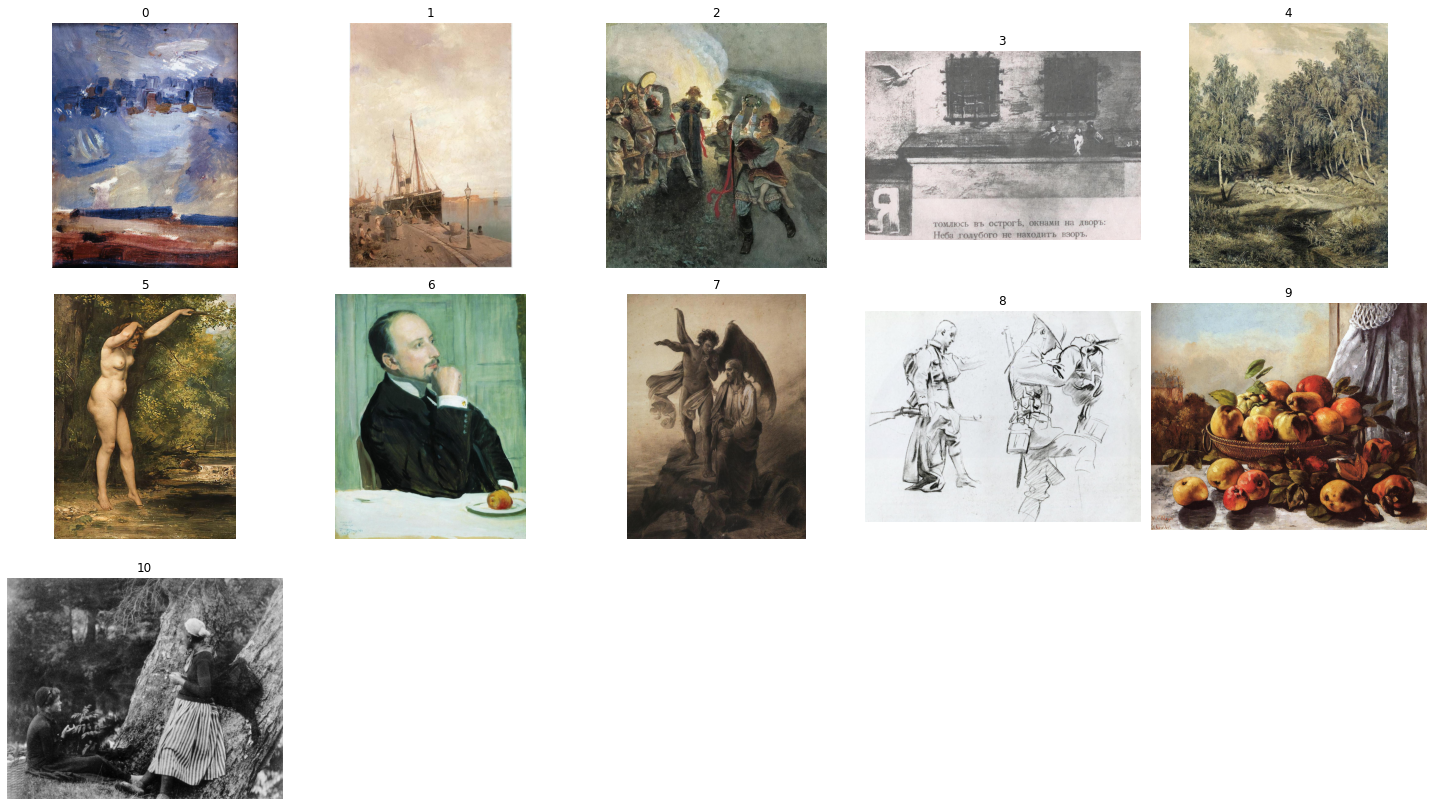

In [14]:
unique_genres = set(dataset['genre_label'])
list_of_images_g = []
for genre in unique_genres:
    for i in range(len(dataset)):
        if dataset[i]['genre_label'] == genre:
            list_of_images_g.append(dataset[i]['image'])
            break

plt.figure(figsize=(20, 20))
for i in range(len(list_of_images_g)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(list_of_images_g[i])
    plt.title(f"{list(unique_genres)[i]}")
    plt.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


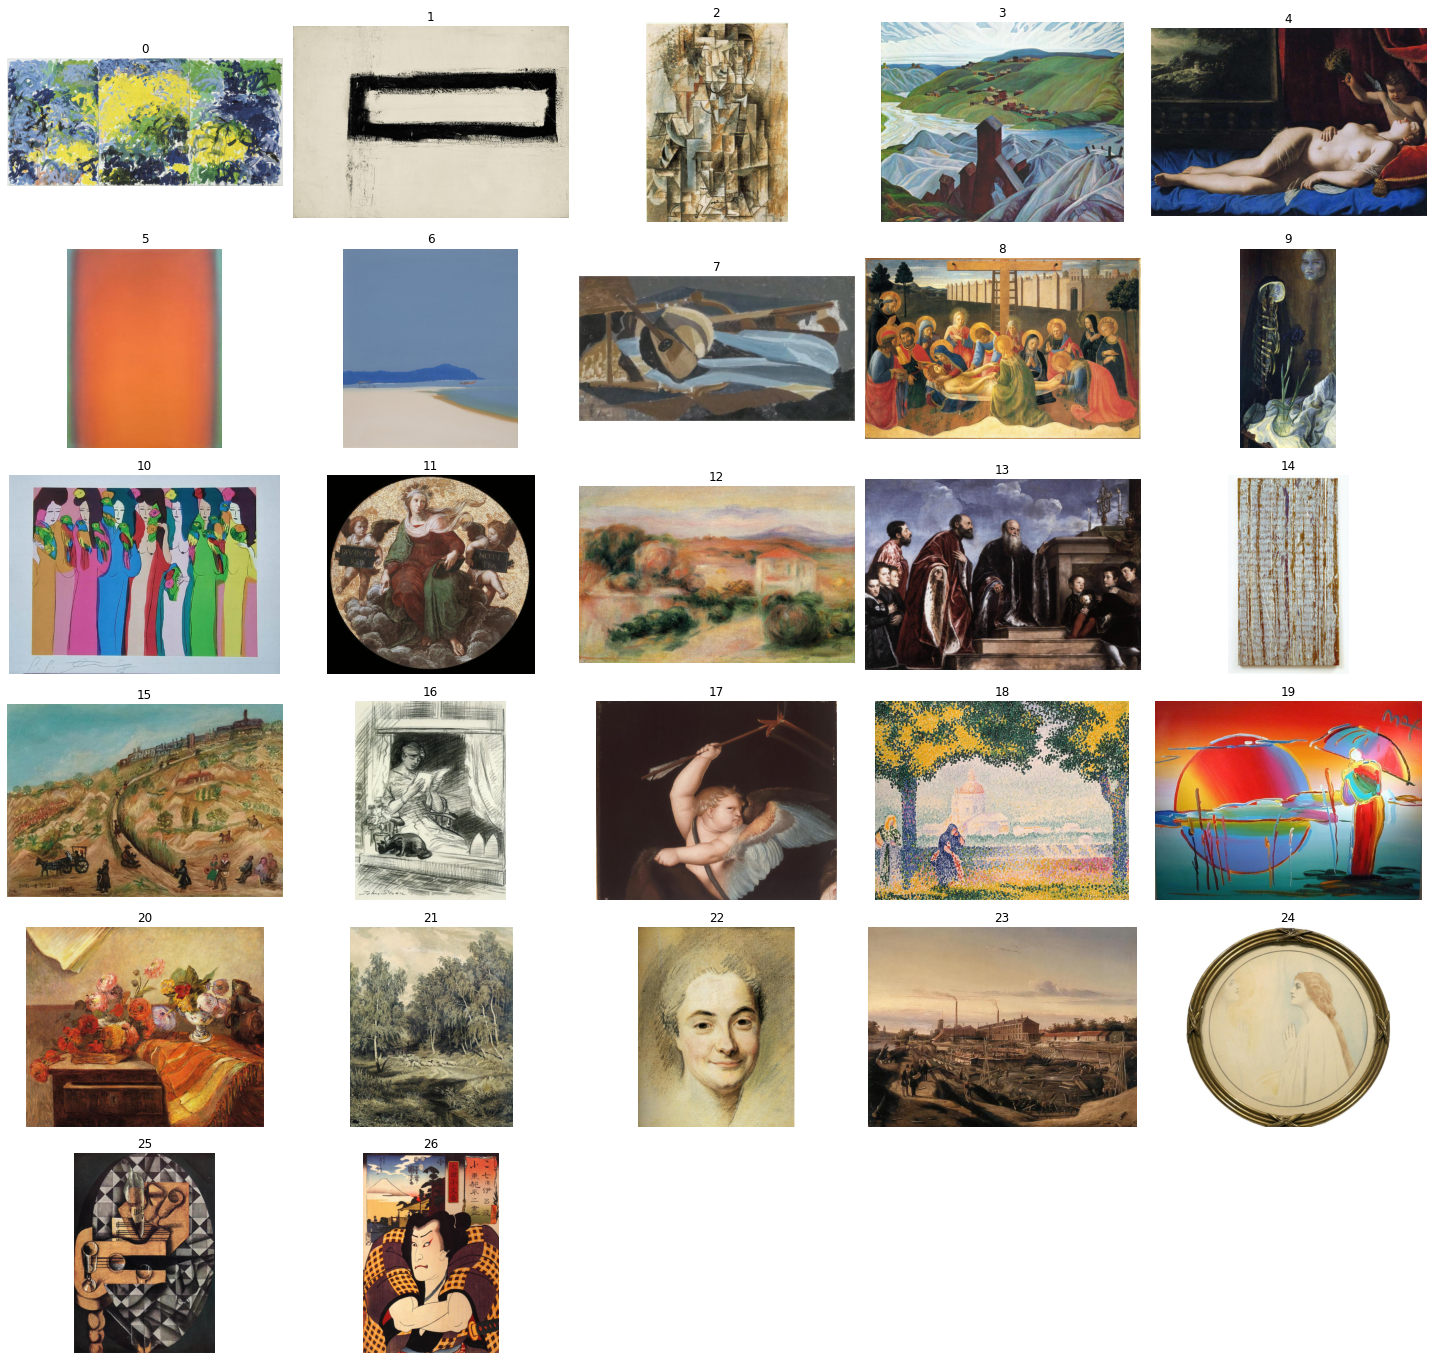

In [15]:
unique_styles = list(set(dataset['style_label']))
list_of_images_s = []
for style in unique_styles:
    for i in range(len(dataset)):
        if dataset[i]['style_label'] == style:
            list_of_images_s.append(dataset[i]['image'])
            break

plt.figure(figsize=(20, 20))
for i in range(len(list_of_images_s)):
    plt.subplot(6, 5, i + 1)
    plt.imshow(list_of_images_s[i])
    plt.title(f"{unique_styles[i]}")
    plt.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Preprocessing images

In [16]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

def preprocess(example):
    inputs = processor(images=example['image'], return_tensors="pt")
    example['pixel_values'] = inputs['pixel_values'][0]
    return example

dataset = dataset.map(preprocess)

Map: 100%|██████████| 2646/2646 [02:20<00:00, 18.81 examples/s]


#### Splitting dataset into train and test sets

In [17]:
def collate_fn(examples):
    pixel_values = torch.stack([
        torch.tensor(example["pixel_values"]) if not isinstance(example["pixel_values"], torch.Tensor)
        else example["pixel_values"]
        for example in examples
    ])
    genre_labels = torch.tensor([example["genre_label"] for example in examples])
    style_labels = torch.tensor([example["style_label"] for example in examples])
    return {
        "pixel_values": pixel_values,
        "genre_labels": genre_labels,
        "style_labels": style_labels
    }

In [18]:
split = dataset.train_test_split(test_size=0.2)
train_dataset = split['train']
eval_dataset = split['test']

### Model

In [19]:
class ViTMultiTask(nn.Module):
    def __init__(self, num_genres, num_styles):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        hidden_size = self.vit.config.hidden_size
        self.genre_head = nn.Linear(hidden_size, num_genres)
        self.style_head = nn.Linear(hidden_size, num_styles)

    def forward(self, pixel_values, **kwargs):
        outputs = self.vit(pixel_values=pixel_values)
        pooled = outputs.pooler_output
        genre_logits = self.genre_head(pooled)
        style_logits = self.style_head(pooled)
        return genre_logits, style_logits

In [20]:
# Initialize the ViT model with your genre classes
model = ViTMultiTask(num_genres=len(genres), num_styles=len(styles))
model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTMultiTask(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, o

In [21]:
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
def compute_metrics(eval_pred: EvalPrediction):
    # Extract and convert to numpy if needed
    genre_logits, style_logits = eval_pred.predictions
    if isinstance(genre_logits, torch.Tensor):
        genre_logits = genre_logits.cpu().numpy()
        style_logits = style_logits.cpu().numpy()
    
    genre_labels = eval_pred.label_ids["genre_labels"]
    style_labels = eval_pred.label_ids["style_labels"]
    if isinstance(genre_labels, torch.Tensor):
        genre_labels = genre_labels.cpu().numpy()
        style_labels = style_labels.cpu().numpy()
    
    genre_preds = np.argmax(genre_logits, axis=1)
    style_preds = np.argmax(style_logits, axis=1)
    genre_acc = (genre_preds == genre_labels).mean()
    style_acc = (style_preds == style_labels).mean()
    avg_acc = (genre_acc + style_acc) / 2
    return {
        "eval_genre_accuracy": genre_acc,
        "eval_style_accuracy": style_acc,
        "eval_avg_accuracy": avg_acc
    }

In [22]:
class MultiTaskTrainer(Trainer):
    def __init__(self, *args, compute_metrics=None, **kwargs):
        super().__init__(*args, compute_metrics=compute_metrics, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        pixel_values = inputs["pixel_values"].to(model.vit.device)
        genre_labels = inputs["genre_labels"].to(model.vit.device)
        style_labels = inputs["style_labels"].to(model.vit.device)
        genre_logits, style_logits = model(pixel_values)
        loss_fct = nn.CrossEntropyLoss()
        genre_loss = loss_fct(genre_logits, genre_labels)
        style_loss = loss_fct(style_logits, style_labels)
        loss = genre_loss + style_loss 
        if return_outputs:
            outputs = (genre_logits, style_logits)
            return loss, outputs
        return loss

    def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
        # Move inputs to appropriate device
        for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
                inputs[k] = v.to(model.vit.device)

        with torch.no_grad():
            # Forward pass
            genre_logits, style_logits = model(inputs["pixel_values"])

            # Get labels
            genre_labels = inputs["genre_labels"]
            style_labels = inputs["style_labels"]

            # Compute loss
            loss_fct = nn.CrossEntropyLoss()
            genre_loss = loss_fct(genre_logits, genre_labels)
            style_loss = loss_fct(style_logits, style_labels)
            loss = genre_loss + style_loss

        if prediction_loss_only:
            return (loss, None, None)

        return (
            loss.detach(),
            (genre_logits.detach(), style_logits.detach()),
            {"genre_labels": genre_labels.detach(),
             "style_labels": style_labels.detach()}
        )

In [23]:
train_args = TrainingArguments(
    output_dir="output-models",
    per_device_train_batch_size=16,
    num_train_epochs=2,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
    eval_strategy='steps',
    metric_for_best_model='eval_avg_accuracy', 
)

In [24]:
trainer = MultiTaskTrainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)
trainer.train()

c:\Users\Wiktoria\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\vit\modeling_vit.py:277: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


TrainOutput(global_step=266, training_loss=2.9108596314164927, metrics={'train_runtime': 3796.711, 'train_samples_per_second': 1.115, 'train_steps_per_second': 0.07, 'total_flos': 0.0, 'train_loss': 2.9108596314164927, 'epoch': 2.0})

#### Save model

In [26]:
torch.save(model.state_dict(), "models/original_model.pt")
original_size = os.path.getsize("models/original_model.pt") / 1e6

In [27]:
print(f"Original model size: {original_size:.2f} MB")

Original model size: 345.76 MB


#### Evaluation

In [28]:
import time

start_time = time.time()
outputs = trainer.predict(eval_dataset)
end_time = time.time()

inference_time_original_model = end_time - start_time
print(f"Inference time for original model: {inference_time_original_model:.2f} seconds")
print(outputs.metrics)


Inference time for original model: 93.25 seconds
{'test_loss': 2.698852062225342, 'test_eval_genre_accuracy': 0.6679245283018868, 'test_eval_style_accuracy': 0.5075471698113208, 'test_eval_avg_accuracy': 0.5877358490566038, 'test_runtime': 93.2496, 'test_samples_per_second': 5.684, 'test_steps_per_second': 0.719}


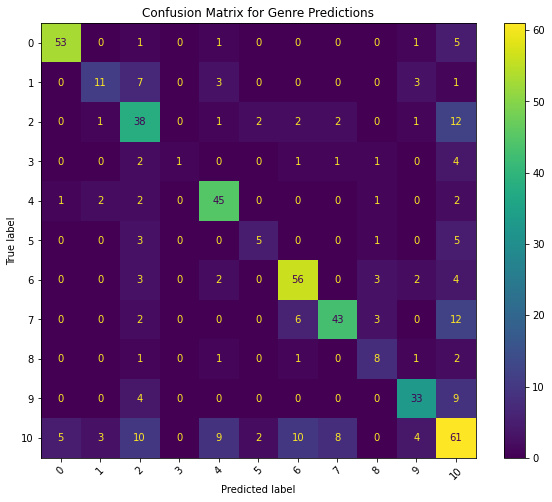

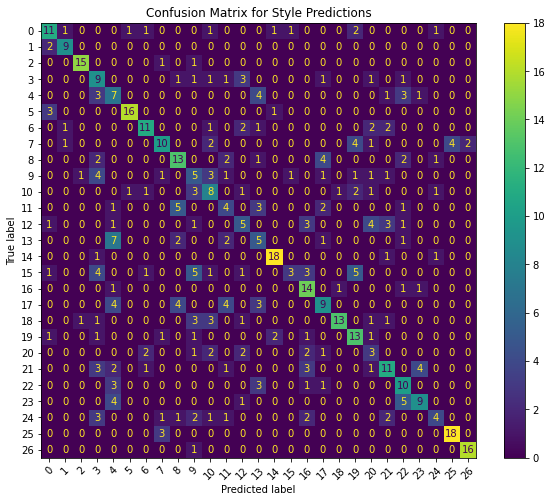

In [29]:
# Extract predictions and true labels for genres and styles
genre_logits, style_logits = outputs.predictions
genre_preds = np.argmax(genre_logits, axis=1)
style_preds = np.argmax(style_logits, axis=1)

genre_labels = outputs.label_ids["genre_labels"]
style_labels = outputs.label_ids["style_labels"]

# Compute confusion matrices
genre_cm = confusion_matrix(genre_labels, genre_preds)
style_cm = confusion_matrix(style_labels, style_preds)

# Display confusion matrix for genres
plt.figure(figsize=(10, 8))
genre_disp = ConfusionMatrixDisplay(confusion_matrix=genre_cm, display_labels=id2label.values())
genre_disp.plot(xticks_rotation=45, cmap="viridis", ax=plt.gca())
plt.title("Confusion Matrix for Genre Predictions")
plt.show()

# Display confusion matrix for styles
plt.figure(figsize=(10, 8))
style_disp = ConfusionMatrixDisplay(confusion_matrix=style_cm, display_labels=id2style.values())
style_disp.plot(xticks_rotation=45, cmap="viridis", ax=plt.gca())
plt.title("Confusion Matrix for Style Predictions")
plt.show()

In [30]:
print(classification_report(genre_labels, genre_preds, target_names=dataset.features["genre"].names))

                    precision    recall  f1-score   support

 abstract_painting       0.90      0.87      0.88        61
         cityscape       0.65      0.44      0.52        25
    genre_painting       0.52      0.64      0.58        59
      illustration       1.00      0.10      0.18        10
         landscape       0.73      0.85      0.78        53
     nude_painting       0.56      0.36      0.43        14
          portrait       0.74      0.80      0.77        70
religious_painting       0.80      0.65      0.72        66
  sketch_and_study       0.47      0.57      0.52        14
        still_life       0.73      0.72      0.73        46
     Unknown Genre       0.52      0.54      0.53       112

          accuracy                           0.67       530
         macro avg       0.69      0.59      0.60       530
      weighted avg       0.68      0.67      0.66       530



In [31]:
print(classification_report(style_labels, style_preds, target_names=dataset.features["style"].names))

                            precision    recall  f1-score   support

    Abstract_Expressionism       0.58      0.55      0.56        20
           Action_painting       0.75      0.82      0.78        11
         Analytical_Cubism       0.88      0.88      0.88        17
               Art_Nouveau       0.29      0.47      0.36        19
                   Baroque       0.23      0.37      0.29        19
      Color_Field_Painting       0.89      0.80      0.84        20
      Contemporary_Realism       0.65      0.55      0.59        20
                    Cubism       0.59      0.42      0.49        24
         Early_Renaissance       0.50      0.52      0.51        25
             Expressionism       0.21      0.25      0.23        20
                   Fauvism       0.35      0.42      0.38        19
          High_Renaissance       0.25      0.25      0.25        16
             Impressionism       0.31      0.26      0.29        19
Mannerism_Late_Renaissance       0.25      0.28

### Quantization dynamic

In [ ]:
# model_v2 = model

model_v2 = ViTMultiTask(num_genres=len(genres), num_styles=len(styles))
model_v2.load_state_dict(torch.load("models/original_model.pt"))

model_v2.eval()

quantized_model = torch.quantization.quantize_dynamic(
    model_v2, 
    {torch.nn.Linear},
    dtype=torch.qint8
)

#int8 is an integer type, it can be used for any operation which needs integers
# qint8 is a quantized tensor type which represents a compressed floating point tensor, it has an underlying int8 data layer, a scale, a zero_point and a qscheme

# Quantization works only on CPU
quantized_model.to("cpu")

torch.save(quantized_model.state_dict(), "models/quantized_model.pt")
quantized_size = os.path.getsize("models/quantized_model.pt") / 1e6  # w MB

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
print(f"Original model size: {original_size:.2f} MB")
print(f"Quantized model size: {quantized_size:.2f} MB")

Original model size: 345.76 MB
Quantized model size: 89.15 MB


In [39]:
quantized_model.eval()
quantized_model.to("cpu")

eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

all_genre_preds = []
all_style_preds = []
all_genre_labels = []
all_style_labels = []

start_time = time.time()
with torch.no_grad():
    for batch in eval_dataloader:
        pixel_values = batch["pixel_values"].to("cpu")
        genre_labels = batch["genre_labels"].to("cpu")
        style_labels = batch["style_labels"].to("cpu")

        genre_logits, style_logits = quantized_model(pixel_values)

        genre_preds = torch.argmax(genre_logits, dim=1)
        style_preds = torch.argmax(style_logits, dim=1)

        all_genre_preds.append(genre_preds.numpy())
        all_style_preds.append(style_preds.numpy())
        all_genre_labels.append(genre_labels.numpy())
        all_style_labels.append(style_labels.numpy())

end_time = time.time()

inference_time_quantized_model = end_time - start_time
print(f"Inference time for quantized model: {inference_time_quantized_model:.2f} seconds")

genre_preds = np.concatenate(all_genre_preds)
style_preds = np.concatenate(all_style_preds)
genre_labels = np.concatenate(all_genre_labels)
style_labels = np.concatenate(all_style_labels)


Inference time for quantized model: 101.83 seconds


In [ ]:
print(f"Inference time for original model: {inference_time_original_model:.2f} seconds")
print(f"Inference time for quantized model: {inference_time_quantized_model:.2f} seconds") 

Inference time for original model: 93.25 seconds
Inference time for original model: 101.98 seconds


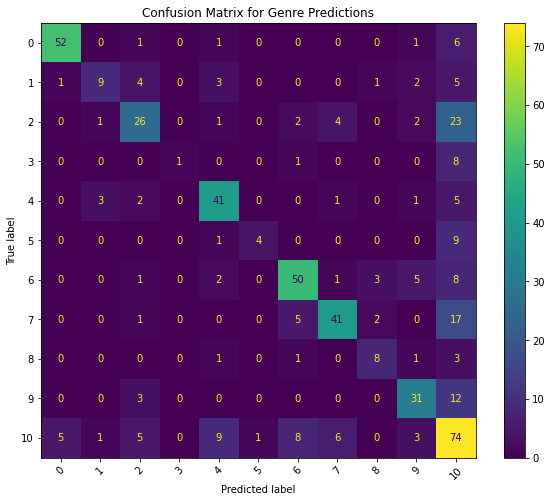

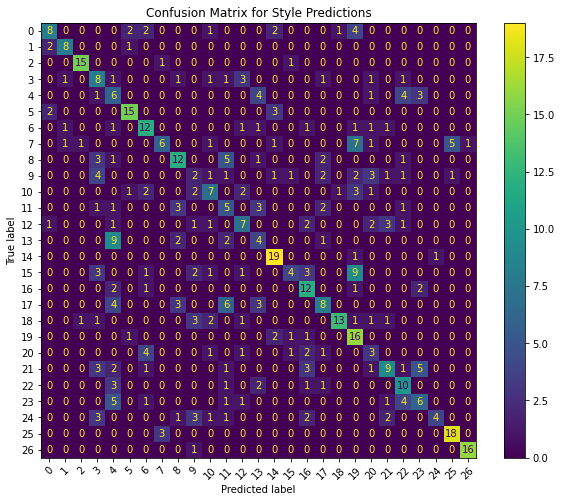

In [40]:
genre_cm = confusion_matrix(genre_labels, genre_preds)
style_cm = confusion_matrix(style_labels, style_preds)

plt.figure(figsize=(10, 8))
genre_disp = ConfusionMatrixDisplay(confusion_matrix=genre_cm, display_labels=id2label.values())
genre_disp.plot(xticks_rotation=45, cmap="viridis", ax=plt.gca())
plt.title("Confusion Matrix for Genre Predictions")
plt.show()

plt.figure(figsize=(10, 8))
style_disp = ConfusionMatrixDisplay(confusion_matrix=style_cm, display_labels=id2style.values())
style_disp.plot(xticks_rotation=45, cmap="viridis", ax=plt.gca())
plt.title("Confusion Matrix for Style Predictions")
plt.show()

In [41]:
print(classification_report(genre_labels, genre_preds, target_names=dataset.features["genre"].names))

                    precision    recall  f1-score   support

 abstract_painting       0.90      0.85      0.87        61
         cityscape       0.64      0.36      0.46        25
    genre_painting       0.60      0.44      0.51        59
      illustration       1.00      0.10      0.18        10
         landscape       0.69      0.77      0.73        53
     nude_painting       0.80      0.29      0.42        14
          portrait       0.75      0.71      0.73        70
religious_painting       0.77      0.62      0.69        66
  sketch_and_study       0.57      0.57      0.57        14
        still_life       0.67      0.67      0.67        46
     Unknown Genre       0.44      0.66      0.52       112

          accuracy                           0.64       530
         macro avg       0.71      0.55      0.58       530
      weighted avg       0.67      0.64      0.63       530



In [42]:
print(classification_report(style_labels, style_preds, target_names=dataset.features["style"].names))

                            precision    recall  f1-score   support

    Abstract_Expressionism       0.62      0.40      0.48        20
           Action_painting       0.73      0.73      0.73        11
         Analytical_Cubism       0.88      0.88      0.88        17
               Art_Nouveau       0.30      0.42      0.35        19
                   Baroque       0.17      0.32      0.22        19
      Color_Field_Painting       0.75      0.75      0.75        20
      Contemporary_Realism       0.50      0.60      0.55        20
                    Cubism       0.60      0.25      0.35        24
         Early_Renaissance       0.55      0.48      0.51        25
             Expressionism       0.14      0.10      0.12        20
                   Fauvism       0.41      0.37      0.39        19
          High_Renaissance       0.21      0.31      0.25        16
             Impressionism       0.41      0.37      0.39        19
Mannerism_Late_Renaissance       0.22      0.22

### Quantization static

In [47]:
from torch.utils.data import Subset

subset_size = int(0.1 * len(train_dataset))
calibration_subset = Subset(train_dataset, list(range(subset_size)))

calibration_loader = DataLoader(
    calibration_subset, batch_size=16, shuffle=False, collate_fn=collate_fn
)

model_v3 = ViTMultiTask(num_genres=len(genres), num_styles=len(styles))
model_v3.load_state_dict(torch.load("models/original_model.pt"))

model_v3.eval()

model_v3.qconfig = torch.quantization.get_default_qconfig('fbgemm')
# fbgemm - backend kwantyzacji
# torch.qint8 – dla wag (signed int8)
# torch.quint8 – dla aktywacji (unsigned int8)

torch.quantization.prepare(model_v3, inplace=True)
# Kalibracja
with torch.no_grad():
    for batch in calibration_loader:
        pixel_values = batch["pixel_values"]
        model_v3(pixel_values)
torch.quantization.convert(model_v3, inplace=True)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTMultiTask(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): QuantizedConv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), scale=0.11896070837974548, zero_point=64)
      )
      (dropout): QuantizedDropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): QuantizedLinear(in_features=768, out_features=768, scale=0.15366865694522858, zero_point=64, qscheme=torch.per_channel_affine)
              (key): QuantizedLinear(in_features=768, out_features=768, scale=0.13611067831516266, zero_point=64, qscheme=torch.per_channel_affine)
              (value): QuantizedLinear(in_features=768, out_features=768, scale=0.05000394210219383, zero_point=62, qscheme=torch.per_channel_affine)
              (dropout): QuantizedDropout(p=0.0, inplace=False)
            )


In [48]:
# Quantization works only on CPU
model_v3.to("cpu")

torch.save(model_v3.state_dict(), "models/static_quantized_model.pt")
static_quantized_size = os.path.getsize("models/static_quantized_model.pt") / 1e6  # w MB

In [49]:
print(f"Original model size: {original_size:.2f} MB")
print(f"Quantized model size: {quantized_size:.2f} MB")
print(f"Quantized model qint4 size: {static_quantized_size:.2f} MB")

Original model size: 345.76 MB
Quantized model size: 89.15 MB
Quantized model qint4 size: 88.80 MB


In [50]:
quantized_model.eval()
quantized_model.to("cpu")

eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

all_genre_preds = []
all_style_preds = []
all_genre_labels = []
all_style_labels = []

start_time = time.time()
with torch.no_grad():
    for batch in eval_dataloader:
        pixel_values = batch["pixel_values"].to("cpu")
        genre_labels = batch["genre_labels"].to("cpu")
        style_labels = batch["style_labels"].to("cpu")

        genre_logits, style_logits = quantized_model(pixel_values)

        genre_preds = torch.argmax(genre_logits, dim=1)
        style_preds = torch.argmax(style_logits, dim=1)

        all_genre_preds.append(genre_preds.numpy())
        all_style_preds.append(style_preds.numpy())
        all_genre_labels.append(genre_labels.numpy())
        all_style_labels.append(style_labels.numpy())

end_time = time.time()

inference_time_static_quantized_model = end_time - start_time
print(f"Inference time for static quantized model: {inference_time_static_quantized_model:.2f} seconds")

genre_preds = np.concatenate(all_genre_preds)
style_preds = np.concatenate(all_style_preds)
genre_labels = np.concatenate(all_genre_labels)
style_labels = np.concatenate(all_style_labels)


Inference time for static quantized model: 104.74 seconds


In [51]:
print(f"Inference time for original model: {inference_time_original_model:.2f} seconds")
print(f"Inference time for quantized model: {inference_time_quantized_model:.2f} seconds") 
print(f"Inference time for static quantized model: {inference_time_static_quantized_model:.2f} seconds")

Inference time for original model: 93.25 seconds
Inference time for quantized model: 101.83 seconds
Inference time for static quantized model: 104.74 seconds


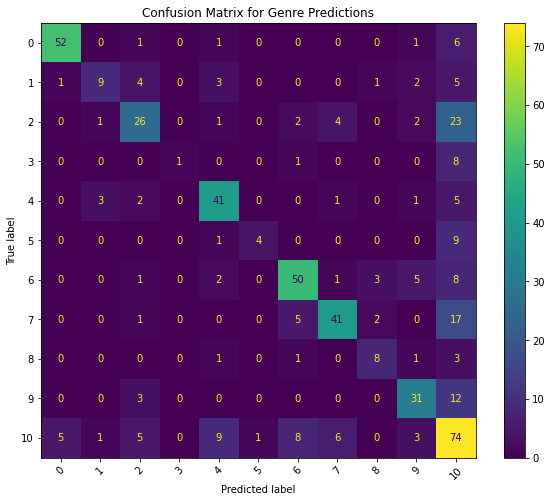

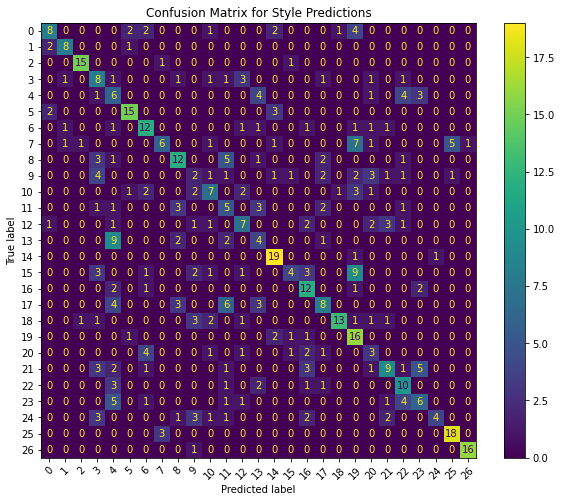

In [52]:
genre_cm = confusion_matrix(genre_labels, genre_preds)
style_cm = confusion_matrix(style_labels, style_preds)

plt.figure(figsize=(10, 8))
genre_disp = ConfusionMatrixDisplay(confusion_matrix=genre_cm, display_labels=id2label.values())
genre_disp.plot(xticks_rotation=45, cmap="viridis", ax=plt.gca())
plt.title("Confusion Matrix for Genre Predictions")
plt.show()

plt.figure(figsize=(10, 8))
style_disp = ConfusionMatrixDisplay(confusion_matrix=style_cm, display_labels=id2style.values())
style_disp.plot(xticks_rotation=45, cmap="viridis", ax=plt.gca())
plt.title("Confusion Matrix for Style Predictions")
plt.show()

In [53]:
print(classification_report(genre_labels, genre_preds, target_names=dataset.features["genre"].names))

                    precision    recall  f1-score   support

 abstract_painting       0.90      0.85      0.87        61
         cityscape       0.64      0.36      0.46        25
    genre_painting       0.60      0.44      0.51        59
      illustration       1.00      0.10      0.18        10
         landscape       0.69      0.77      0.73        53
     nude_painting       0.80      0.29      0.42        14
          portrait       0.75      0.71      0.73        70
religious_painting       0.77      0.62      0.69        66
  sketch_and_study       0.57      0.57      0.57        14
        still_life       0.67      0.67      0.67        46
     Unknown Genre       0.44      0.66      0.52       112

          accuracy                           0.64       530
         macro avg       0.71      0.55      0.58       530
      weighted avg       0.67      0.64      0.63       530



In [54]:
print(classification_report(style_labels, style_preds, target_names=dataset.features["style"].names))

                            precision    recall  f1-score   support

    Abstract_Expressionism       0.62      0.40      0.48        20
           Action_painting       0.73      0.73      0.73        11
         Analytical_Cubism       0.88      0.88      0.88        17
               Art_Nouveau       0.30      0.42      0.35        19
                   Baroque       0.17      0.32      0.22        19
      Color_Field_Painting       0.75      0.75      0.75        20
      Contemporary_Realism       0.50      0.60      0.55        20
                    Cubism       0.60      0.25      0.35        24
         Early_Renaissance       0.55      0.48      0.51        25
             Expressionism       0.14      0.10      0.12        20
                   Fauvism       0.41      0.37      0.39        19
          High_Renaissance       0.21      0.31      0.25        16
             Impressionism       0.41      0.37      0.39        19
Mannerism_Late_Renaissance       0.22      0.22